### Import Libraries

In [1]:
%matplotlib inline

import nibabel as nib
import ants
import numpy as np
import pandas as pd
import os
from math import ceil
import multiprocessing as mp
import re
import gc

from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from nilearn.image import load_img, smooth_img, resample_img, get_data
from nilearn.plotting import show, view_img, plot_img
import intensity_normalization.normalize as norm

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from skimage.measure import compare_ssim
import imutils
import cv2
import scipy

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, model_from_json, Model
from tensorflow.keras.layers import (
    Conv3D,
    MaxPooling3D,
    Conv3DTranspose,
    UpSampling3D,
    BatchNormalization,
    Activation,
    Add,
    Input,
    Lambda,
    Dense,
    Flatten,
    Reshape
)
from tensorflow.keras.utils import plot_model
import tensorflow.keras.losses as losses
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.losses import mean_squared_error

/home/jraad/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning:

Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.



### Define Paths

In [2]:
research_dir = '/media/jraad/Data1/school/research/'
data_dir = os.path.join(research_dir, 'data')
dhcp_dir = os.path.join(data_dir, 'dHCP')
dhcp_norm = os.path.join(dhcp_dir, 'self_normalized')
dhcp_standardized = os.path.join(dhcp_dir, 'standardized')
dhcp_analysis = os.path.join(dhcp_dir, 'analysis')

model_dir = os.path.join(research_dir, 'models', 'new_models')

### Read Data

In [3]:
dhcp_normal_path = os.path.join(dhcp_standardized, 'dhcp_level1_reduced.npy')
dhcp_normal = np.load(dhcp_normal_path)

dhcp_abnormal_path = os.path.join(dhcp_standardized, 'dhcp_level5.npy')
dhcp_abnormal = np.load(dhcp_abnormal_path)

### Prepare Samples

In [4]:
x, y, z = (256, 256, 256)

train = []
num_samples = dhcp_normal.shape[0]

for i in range(0, num_samples):
    train.append(np.reshape(dhcp_normal[i], (x, y, z, 1)))

train = np.asarray(train)

test = []
num_samples = dhcp_abnormal.shape[0]

for i in range(0, num_samples):
    test.append(np.reshape(dhcp_abnormal[i], (x, y, z, 1)))

test  = np.asarray(test)

### Helper Functions

In [142]:
def run_model(model_name, train, test):
    flat_json_dir = os.path.join(model_dir, f'{model_name}.json')
    flat_model_dir = os.path.join(model_dir, f'{model_name}.h5')
    json_file = open(flat_json_dir, 'r')
    model = model_from_json(json_file.read())
    json_file.close()
    model.load_weights(flat_model_dir)
    
    train_results = model.predict(train, batch_size=1)
    test_results = model.predict(test, batch_size=1)
    
    tf.keras.backend.clear_session()
    del model
    gc.collect()
    
    return train_results, test_results

def mse(true, pred):
    return np.mean(np.square(true-pred))

def connected_components_2d(diff):
    a = diff[:,:,128]
    counts, labels = cv2.connectedComponents(a)
    
    return labels

def generate_boxplot(train_clusters, test_clusters):
    train_counts = []
    for x in train_clusters:
        clust, counts = np.unique(x, return_counts=True)
        train_counts.extend(counts[1:])

    test_counts = []
    for x in test_clusters:
        clust, counts = np.unique(x, return_counts=True)
        test_counts.extend(counts[1:])
    
    meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick', markersize=12)

    plt.subplots(figsize=(20,20))
    res = plt.boxplot([train_counts, test_counts], vert=True, labels=['Train', 'Test'], showfliers=False, showmeans=True, meanprops=meanpointprops)
    
def calculate_clusters(diff, threshold=3):
    mean = 0.0075985678
    std = 0.06039284
    mean = 0
    std = 0.1
    results = []
    metrics = []
    for val in diff:
        prepared_diff = np.reshape(val, (256, 256, 256))
        normed_diff = (prepared_diff - mean) / std
        filter_mask = (normed_diff > -threshold) & (normed_diff < threshold)
        normed_diff[filter_mask] = 0
        normed_diff[normed_diff != 0] = 1
        prepared_diff = normed_diff.astype('uint8')

#         prepared_diff = np.round(np.reshape(val, (256, 256, 256)) * 256).astype('uint8')
        clusters = connected_components_2d(prepared_diff)
        results.append(clusters)
        
        values, counts = np.unique(clusters, return_counts=True)
        avg_size = np.mean(counts[1:])
        num_clusters = len(values[1:])
        
        metrics.append({'avg_size': avg_size, 'num_clusters': num_clusters})
    
    return np.array(results), metrics

def calculate_for_roc_prc(train_diff, test_diff):
    mean = np.mean(train_diff)
    std = np.mean(train_diff)

    train_normalized = (train_diff - mean) / std
    test_normalized = (test_diff - mean) / std

    thresh = 0
    train_voxels = []
    train_sums = []
    train_mses = []
    train_means = []
    for img in train_normalized:
        threshed = abs(img) > thresh
        train_voxels.append(np.sum(threshed))
        train_sums.append(np.sum(abs(img[threshed])))
        train_mses.append(np.mean(np.square(img[threshed])))
        train_means.append(np.mean(img[threshed]))

    test_voxels = []
    test_sums = []
    test_mses = []
    test_means = []
    for img in test_normalized:
        threshed = abs(img) > thresh
        test_voxels.append(np.sum(threshed))
        test_sums.append(np.sum(abs(img[threshed])))
        test_mses.append(np.mean(np.square(img[threshed])))
        test_means.append(np.mean(img[threshed]))

    x = train_sums.copy()
    x.extend(test_sums)
    x = np.array(x).reshape(-1, 1)
    train_classes = [0] * len(train_sums)
    y = train_classes.copy()
    y.extend([1] * len(test_sums))
    
    return x, y

def get_whitespace_mask(img):
    new_img = (img * 256.0).astype('uint8')
    _,slz = cv2.threshold(new_img,140,255,cv2.THRESH_BINARY_INV)
    return slz

def roc_curve_plot(x, y):
    ns_probs = [0 for _ in range(len(y))]
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y, x)

    plt.subplots(figsize=(20,20))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def precision_recall_curve_plot(x, y):
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(y, x)

    plt.subplots(figsize=(20,20))
    plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
    plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
    plt.title('Precision and recall for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend()
    plt.show()

def do_whitespace_stuff(x, x_pred):
    x_out = np.zeros(x.shape)
    x_pred_out = np.zeros(x_pred.shape)
    
    for j in range(0, x.shape[0]):
        x_new = np.reshape(x[j], (256, 256, 256))
        x_pred_new = np.reshape(x_pred[j], (256, 256, 256))
        x_masked = np.zeros((256, 256, 256))
        x_pred_masked = np.zeros((256, 256, 256))
        for i in range(0, 256):
            mask = get_whitespace_mask(x_new[:,:,i])
            x_masked[:,:,i] = cv2.bitwise_and(x_new[:,:,i], x_new[:,:,i], mask=mask)
            x_pred_masked[:,:,i] = cv2.bitwise_and(x_pred_new[:,:,i], x_pred_new[:,:,i], mask=mask)
        x_out[j] = np.reshape(x_masked, (256, 256, 256, 1))
        x_pred_out[j] = np.reshape(x_pred_masked, (256, 256, 256, 1))

    return x_out, x_pred_out

def collect_metrics(model_name, train, test):
    train_results, test_results = run_model(model_name, train, test)

    mse_train = mse(train, train_results)
    mse_test = mse(test, test_results)

    print('Train MSE:', mse_train)
    print('Test MSE:', mse_test)
    
    train_masked, train_pred_masked = do_whitespace_stuff(train, train_results)
    test_masked, test_pred_masked = do_whitespace_stuff(test, test_results)
    
    train_diff = train_masked - train_pred_masked
    test_diff = test_masked - test_pred_masked
#     train_diff = train - train_results
#     test_diff = test - test_results

    positive_train = np.mean(train_diff[train_diff > 0])
    negative_train = np.mean(train_diff[train_diff < 0])

    positive_test = np.mean(test_diff[test_diff > 0])
    negative_test = np.mean(test_diff[test_diff < 0])

    print('Train -', 'Positive Changes: ', positive_train, 'Negative Changes: ', negative_train)
    print('Test -', 'Positive Changes: ', positive_test, 'Negative Changes: ', negative_test)

    train_clusters, train_metrics = calculate_clusters(train_diff)
    test_clusters, test_metrics = calculate_clusters(test_diff)
    
    generate_boxplot(train_clusters, test_clusters)

    avg_size_train = np.mean([x['avg_size'] for x in train_metrics])
    avg_clust_train = np.mean([x['num_clusters'] for x in train_metrics])

    avg_size_test = np.mean([x['avg_size'] for x in test_metrics])
    avg_clust_test = np.mean([x['num_clusters'] for x in test_metrics])

    print('Train -', 'Avg Size: ', avg_size_train, 'Avg Clust: ', avg_clust_train)
    print('Test -', 'Avg Size: ', avg_size_test, 'Avg Clust: ', avg_clust_test)
    
    x, y = calculate_for_roc_prc(train_diff, test_diff)
    
    roc_curve_plot(x, y)
    precision_recall_curve_plot(x, y)

def alpha_curve(ncolors):
    x = np.array([0.5, 0.387, 0.24, 0.136, 0.04, 0.011])
    y = np.array([1.255, 1.25, 1.189, 1.124, 0.783, 0.402]) / 1.255

    # this is the function we want to fit to our data
    def func(x, a, b):
        'nonlinear function in a and b to fit to data'
        return a * x / (b + x)

    initial_guess = [1.2, 0.03]
    pars, pcov = curve_fit(func, x, y, p0=initial_guess)

    linspace = np.linspace(0, 1, ncolors)
    color_alpha = func(linspace, pars[0], pars[1])
    color_alpha /= np.amax(color_alpha)
    
    return color_alpha

def brain_diff(a, b, threshold=3, mean=0, std=0.1):
    ncolors = 256
    
    x, y, z = a.shape
    z_plot = ceil(z / 2)
    
    diff = a - b
    
    diff_scaled = np.divide(np.reshape(diff, (x,y,z)) - mean, std, where=std!=0)
    
    # Values that fall below the mean/threshold
    below_zero = diff_scaled.copy()
    below_zero[below_zero > -threshold] = 0

    # Values that fall above the mean/threshold
    above_zero = diff_scaled.copy()
    above_zero[above_zero < threshold] = 0
    
    # Log-ish Alpha scale
    color_alpha = alpha_curve(ncolors)
    
    # Above mean colormap
    color_array = plt.get_cmap('Reds')(range(ncolors))
    color_array[:,-1] = color_alpha
    map_object = LinearSegmentedColormap.from_list(name='above_mean',colors=color_array)
    plt.register_cmap(cmap=map_object)

    # Above mean colormap
    color_array = plt.get_cmap('Blues')(range(ncolors))
    color_array = np.flip(color_array, axis=0)
    color_array[:,-1] = np.flip(color_alpha) #np.linspace(1.0,0.0,ncolors)
    map_object = LinearSegmentedColormap.from_list(name='below_mean',colors=color_array)
    plt.register_cmap(cmap=map_object)
    
    # Define plots
    fig, ax = plt.subplots(3, 1, figsize=(20, 30))
    
    # Plot middle slice
    index = 0
    ax[index].imshow(a[:,:,z_plot], cmap='Greys')
    im = ax[index].imshow(above_zero[:,:,z_plot], cmap='above_mean')
    fig.colorbar(im, ax=ax[index])
    im = ax[index].imshow(below_zero[:,:,z_plot], cmap='below_mean')
    fig.colorbar(im, ax=ax[index])
    
    # Plot early slice
    z_plot = ceil(a.shape[2]/4)
    index = 1
    ax[index].imshow(a[:,:,z_plot], cmap='Greys')
    im = ax[index].imshow(above_zero[:,:,z_plot], cmap='above_mean')
    fig.colorbar(im, ax=ax[index])
    im = ax[index].imshow(below_zero[:,:,z_plot], cmap='below_mean')
    fig.colorbar(im, ax=ax[index])
    
    # Plot late slice
    z_plot = ceil(a.shape[2]/4)
    z_plot *= 3
    index = 2
    ax[index].imshow(a[:,:,z_plot], cmap='Greys')
    im = ax[index].imshow(above_zero[:,:,z_plot], cmap='above_mean')
    fig.colorbar(im, ax=ax[index])
    im = ax[index].imshow(below_zero[:,:,z_plot], cmap='below_mean')
    fig.colorbar(im, ax=ax[index])

In [6]:
train_results, test_results = run_model('dhcp_vae_model_full_8x8comp_reduced_dataset_mse', train ,test)

In [31]:
diff = train - train_results

(89, 8, 8, 1)

In [181]:
ws = 64
x,y,z = (256,256,256)

mean_matrix = np.zeros((x // ws, y // ws, z))
std_matrix = np.zeros((x // ws, y // ws, z))

diff = np.reshape(diff, (89, x, y, z))
for i in range(0, 256):
    for j in range(0, 256, ws):
        for k in range(0, 256, ws):
            v_mean = np.mean(diff[:,j:j+ws,k:k+ws, i])
            v_std = np.std(diff[:,j:j+ws,k:k+ws, i])

            idx = j // ws
            mean_matrix[j // ws, k // ws, i] = v_mean
            std_matrix[j // ws, k // ws, i] = v_std


mm = np.zeros((x, y, z))
sm = np.zeros((x, y, z))

for i in range(0, 256):
    for j in range(0, mean_matrix.shape[0]):
        for k in range(0, mean_matrix.shape[1]):
            j_min = j * ws
            j_max = j_min + ws
            k_min = k * ws
            k_max = k_min + ws
            mm[j_min:j_max, k_min:k_max, i] = mean_matrix[j, k, i]
            sm[j_min:j_max, k_min:k_max, i] = std_matrix[j, k, i]

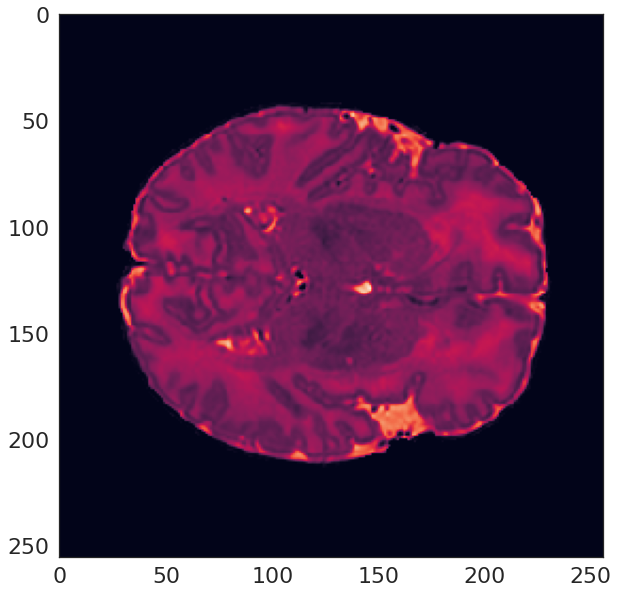

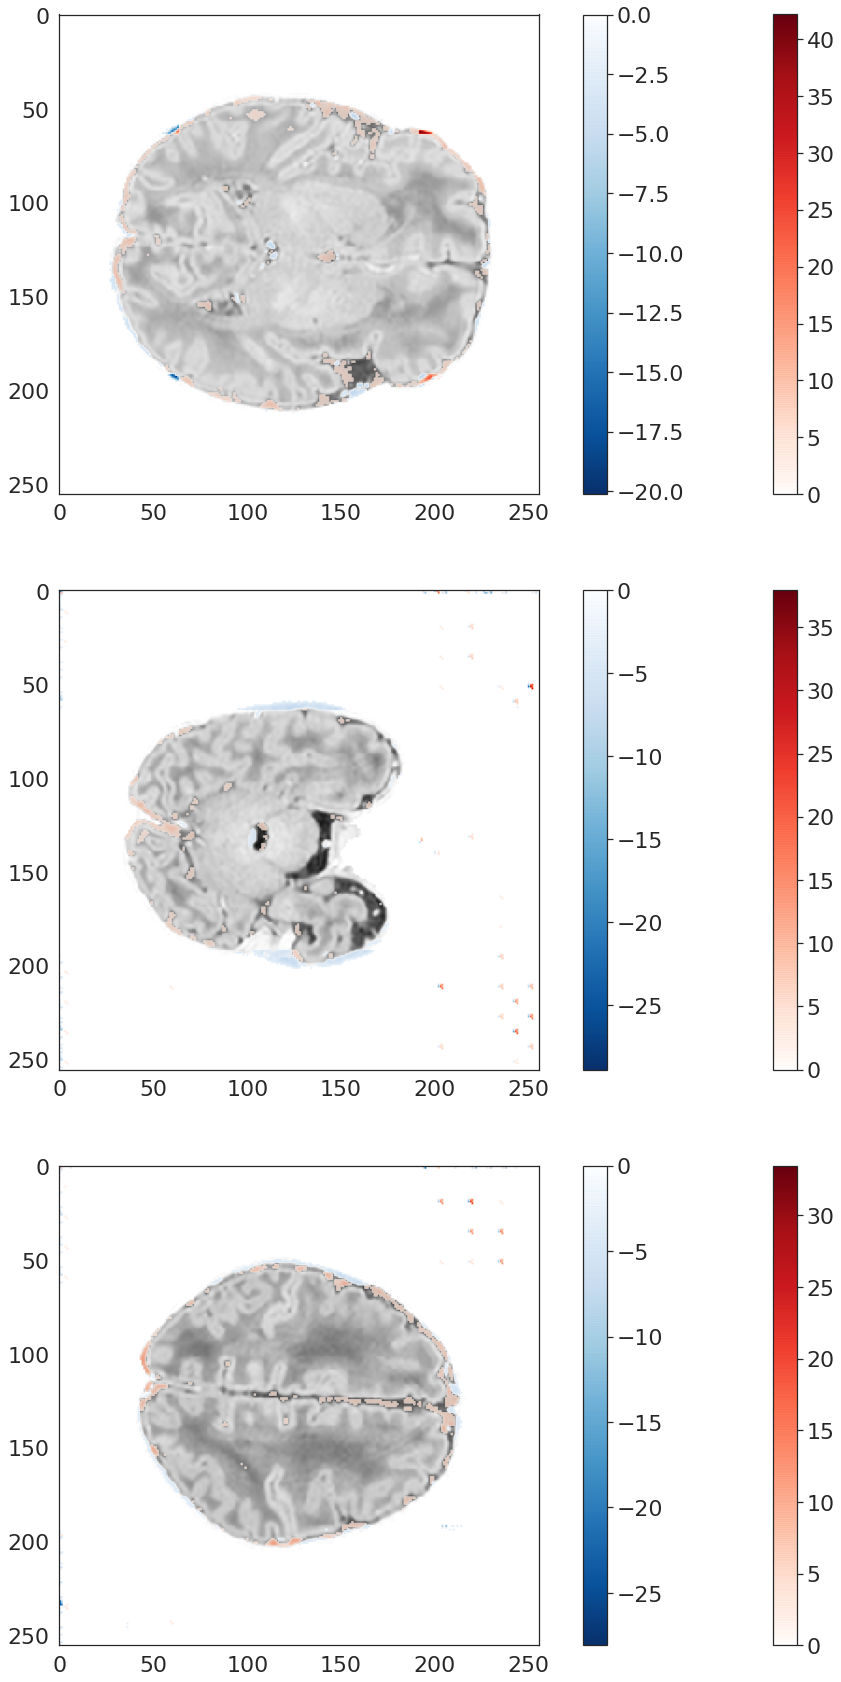

In [184]:
idx = 0
og = np.reshape(train[idx], (256, 256, 256))
pred = np.reshape(train_results[idx], (256, 256, 256))
plt.imshow(train[idx][:,:,128])
brain_diff(og, pred, threshold=3, mean=mm, std=sm)

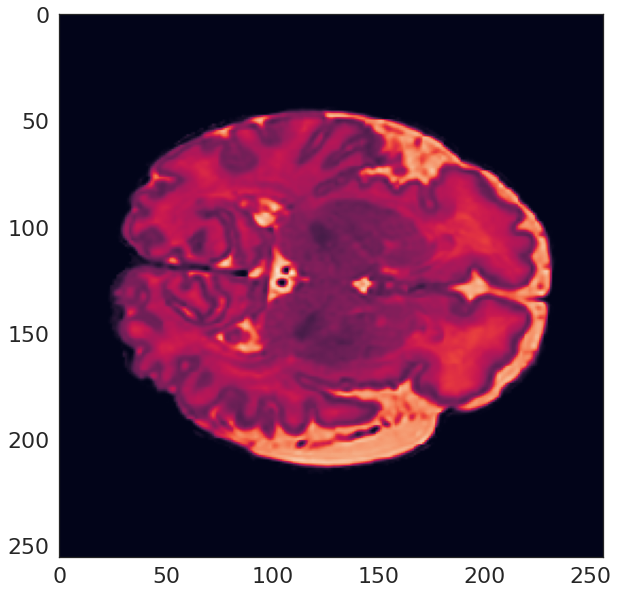

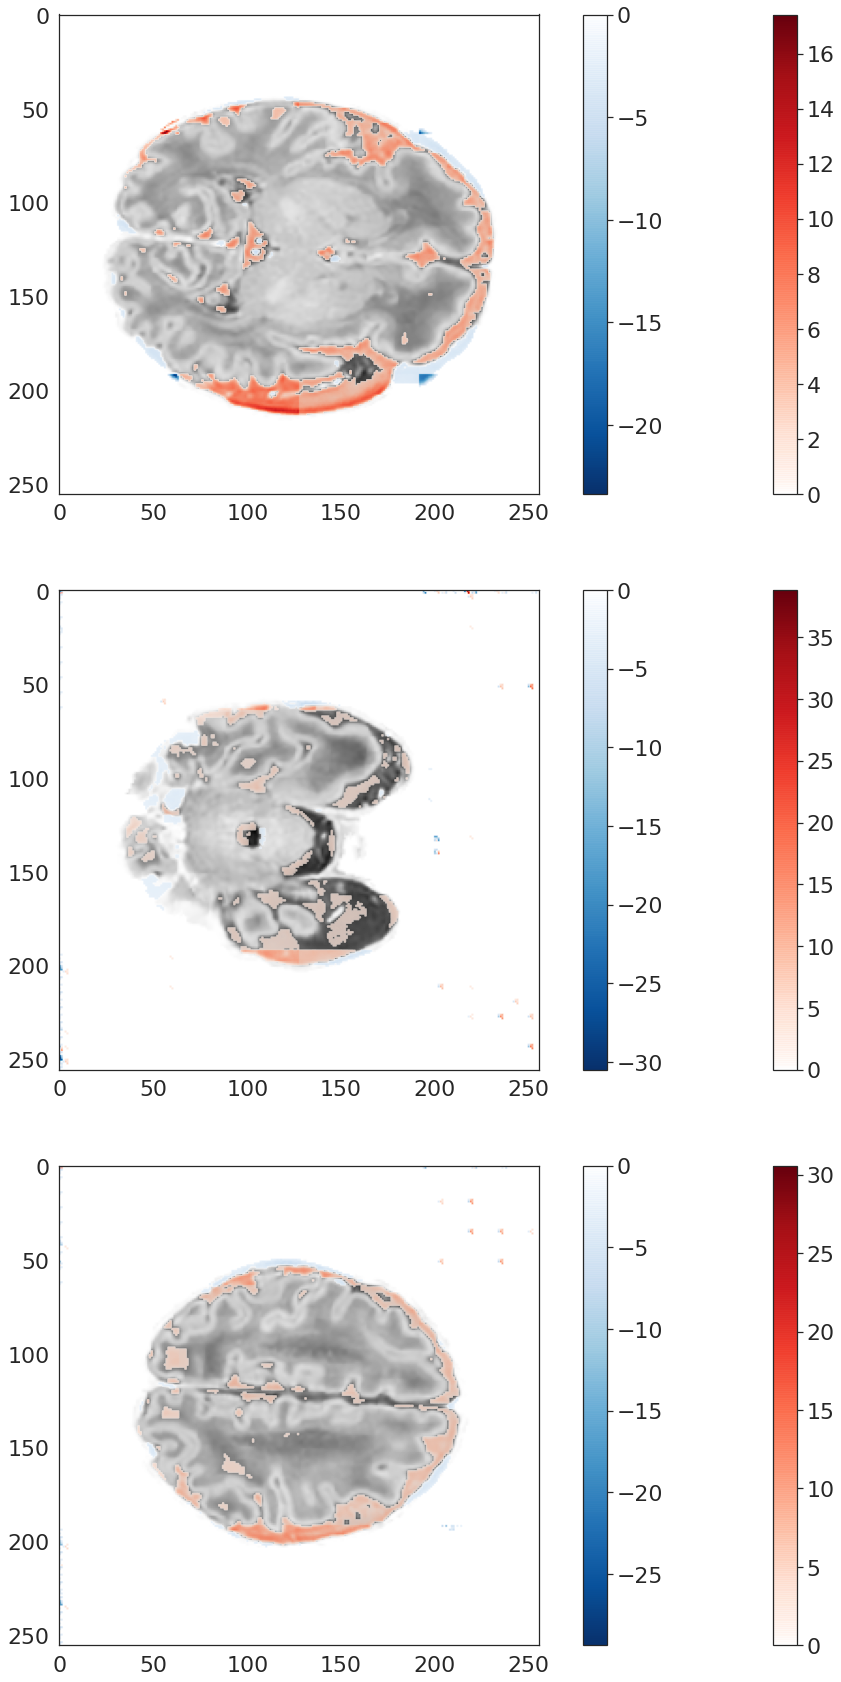

In [183]:
idx = 0
og_test = np.reshape(test[idx], (256, 256, 256))
pred_test = np.reshape(test_results[idx], (256, 256, 256))
plt.imshow(test[idx][:,:,128])
brain_diff(og_test, pred_test, threshold=3, mean=mm, std=sm)

### dhcp_vae_model_full_8x8comp_reduced_dataset_mse

Train MSE: 0.0031521341
Test MSE: 0.0048461333
Train - Positive Changes:  0.010228431708743352 Negative Changes:  -0.0498080494577188
Test - Positive Changes:  0.013578330719669655 Negative Changes:  -0.052374940997293375
Train - Avg Size:  4.341913521356904 Avg Clust:  33.1123595505618
Test - Avg Size:  5.812833607767979 Avg Clust:  35.625


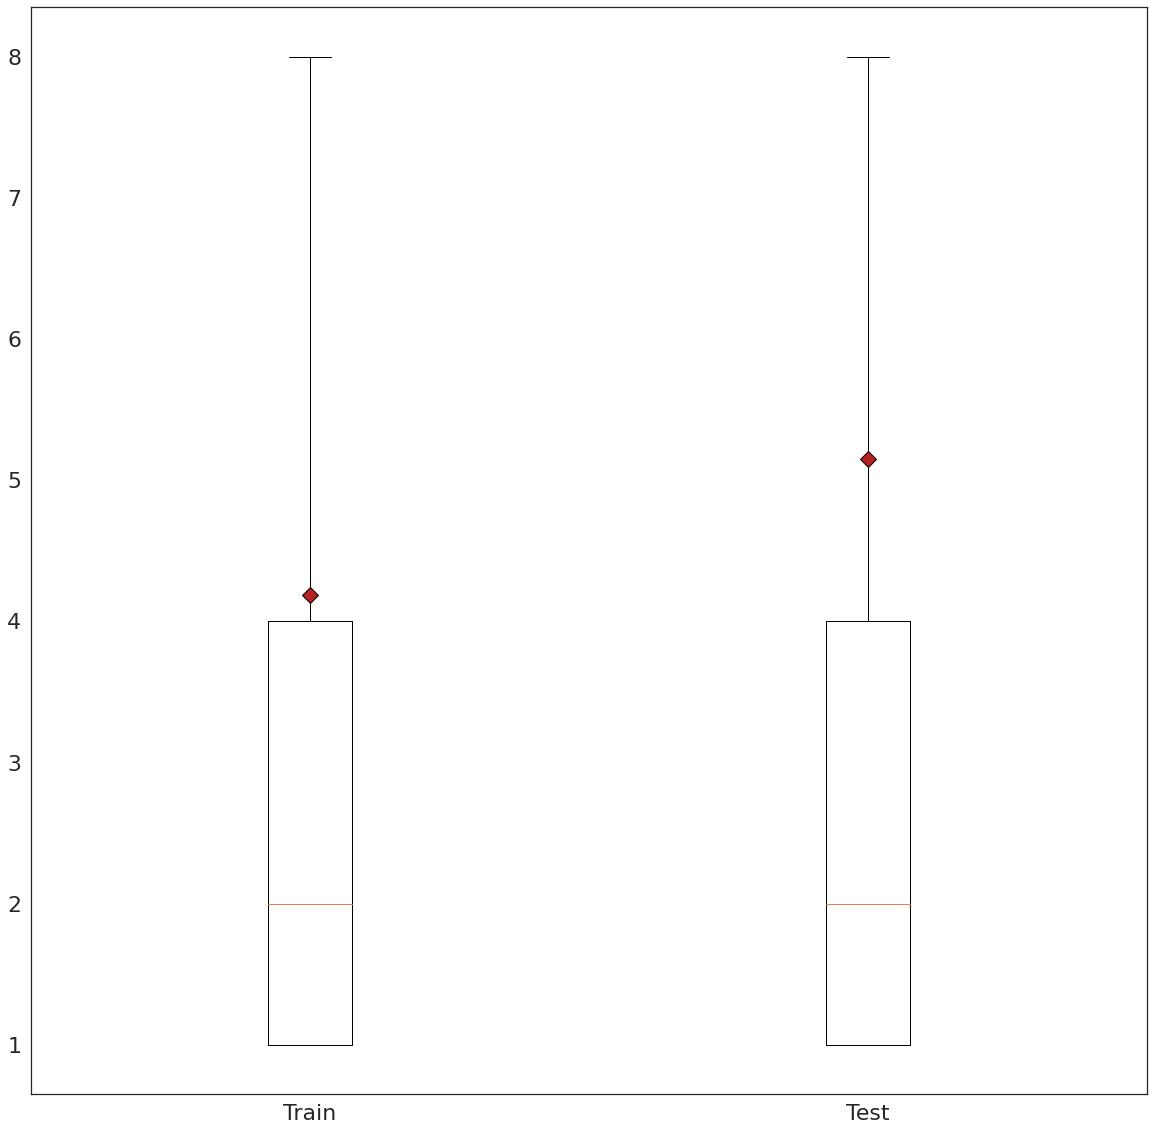

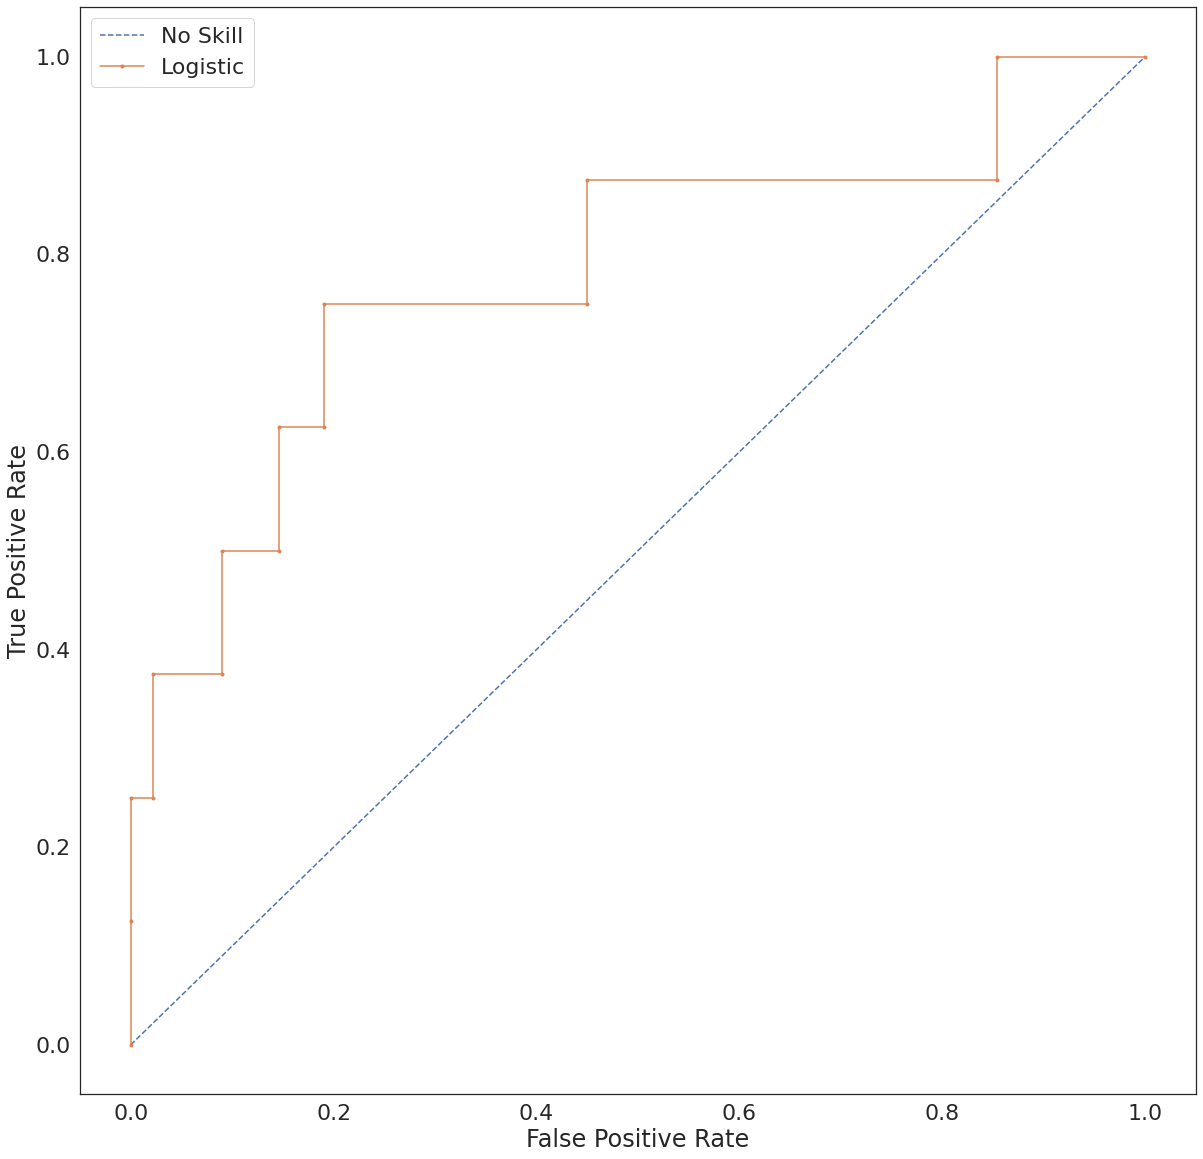

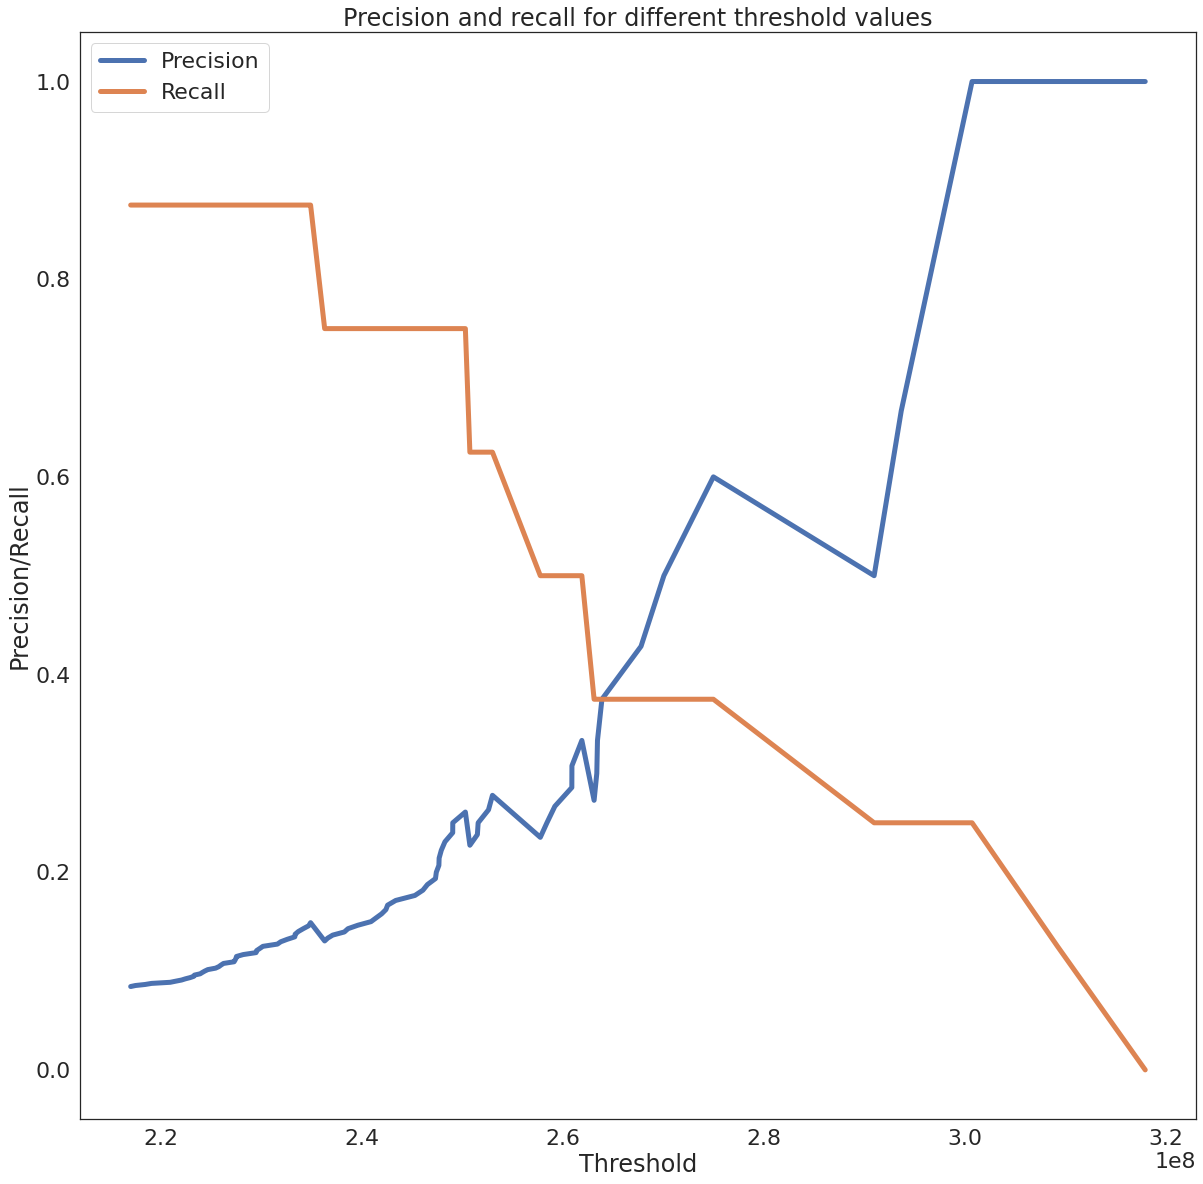

In [132]:
collect_metrics('dhcp_vae_model_full_8x8comp_reduced_dataset_mse', train ,test)

### dhcp_vae_model_full_16x16comp

Train MSE: 0.003119192
Test MSE: 0.004632862
Train - Positive Changes:  0.008789472877128581 Negative Changes:  -0.046640317841499856
Test - Positive Changes:  0.011977950234647716 Negative Changes:  -0.04704953559234009
Train - Avg Size:  4.67150110613233 Avg Clust:  28.03370786516854
Test - Avg Size:  7.0606805891033195 Avg Clust:  29.75


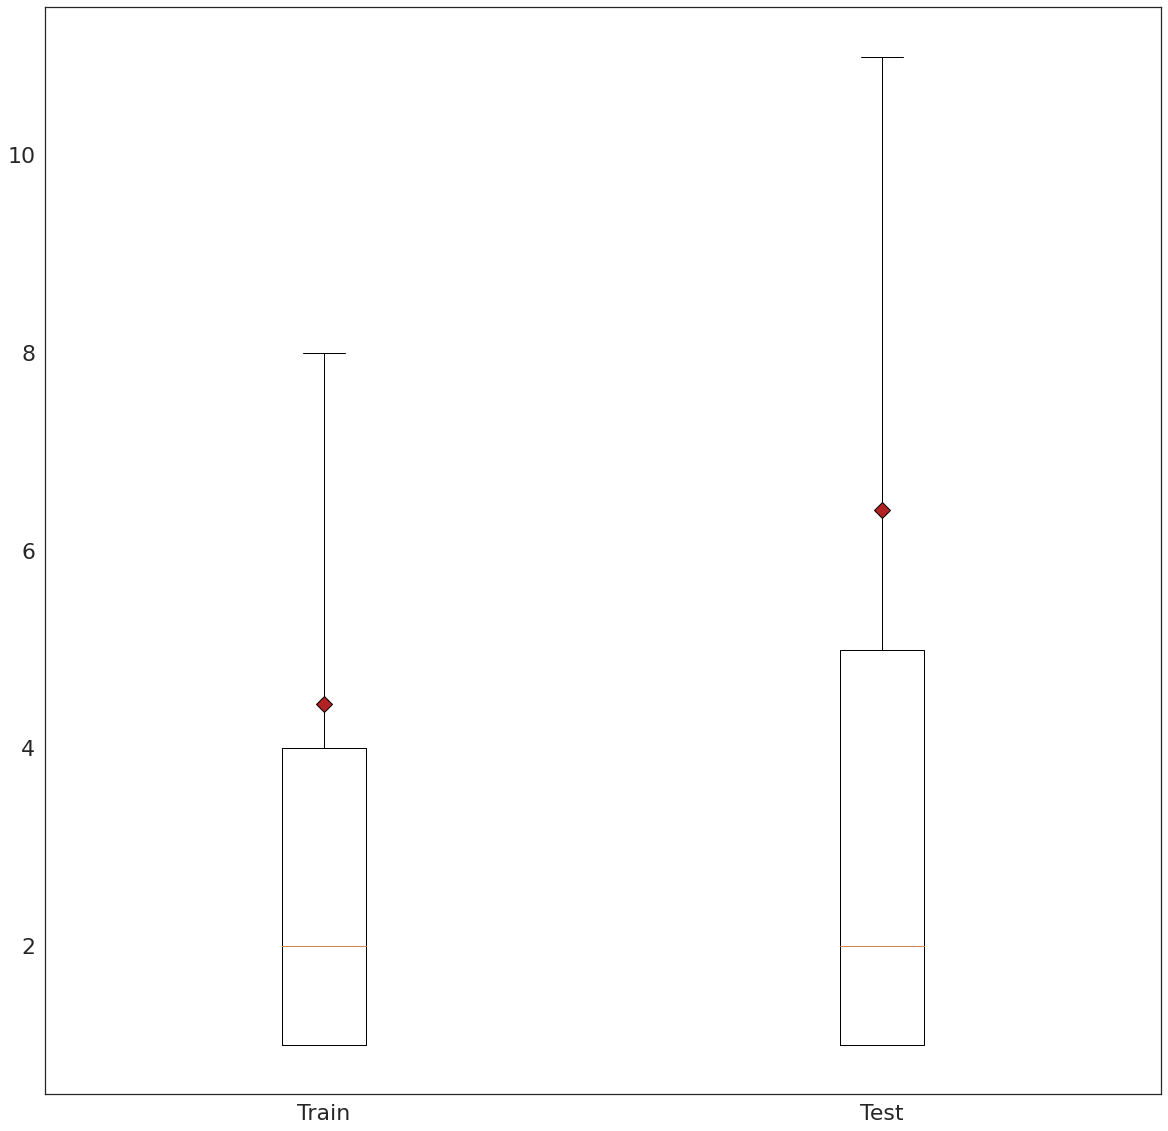

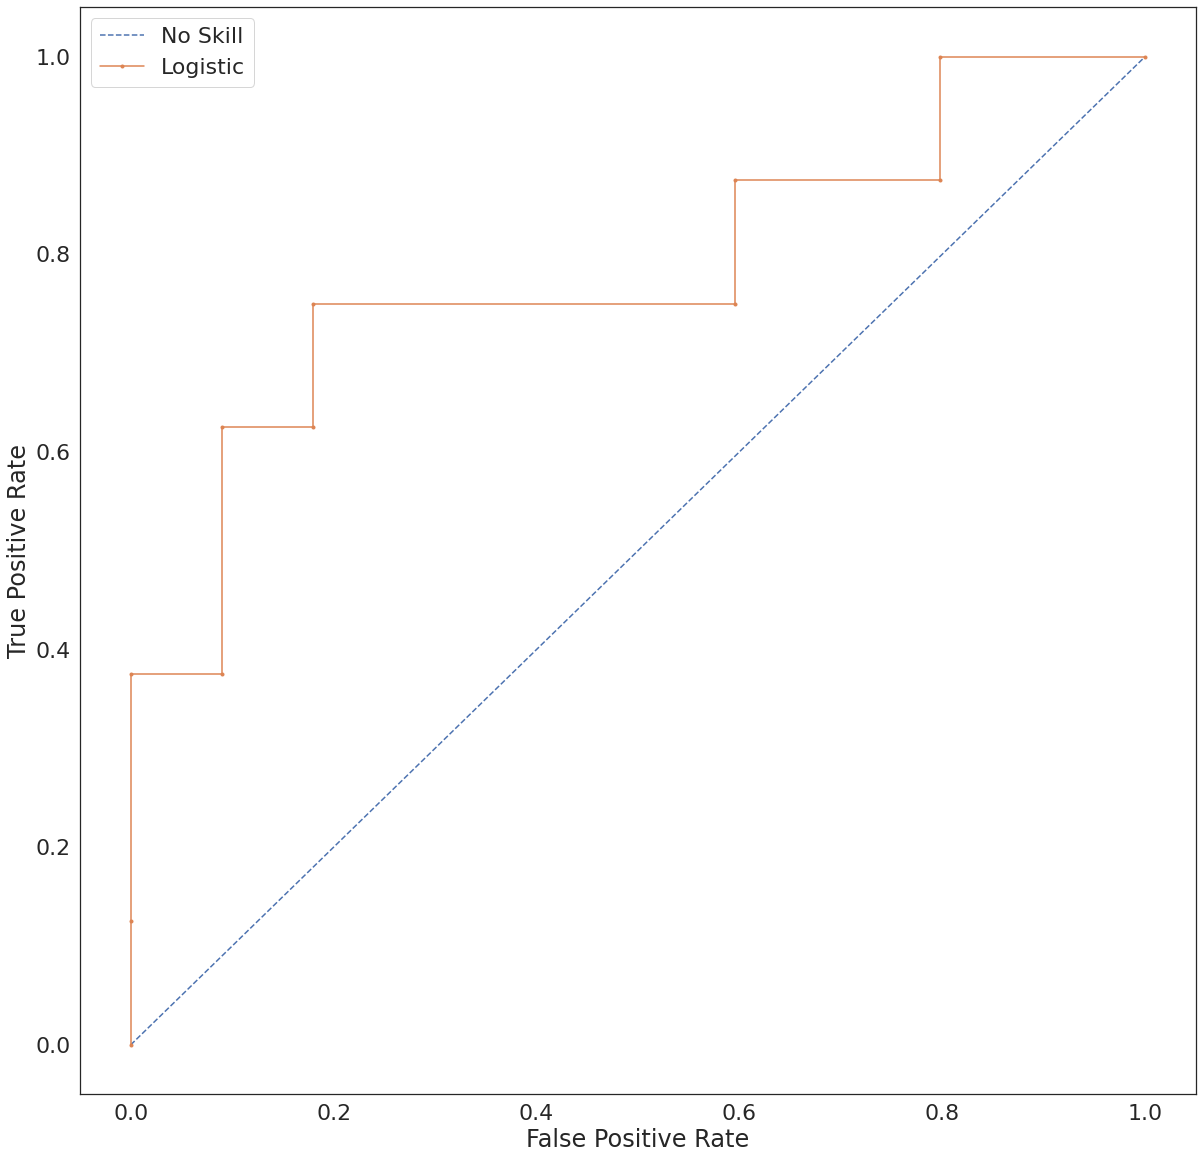

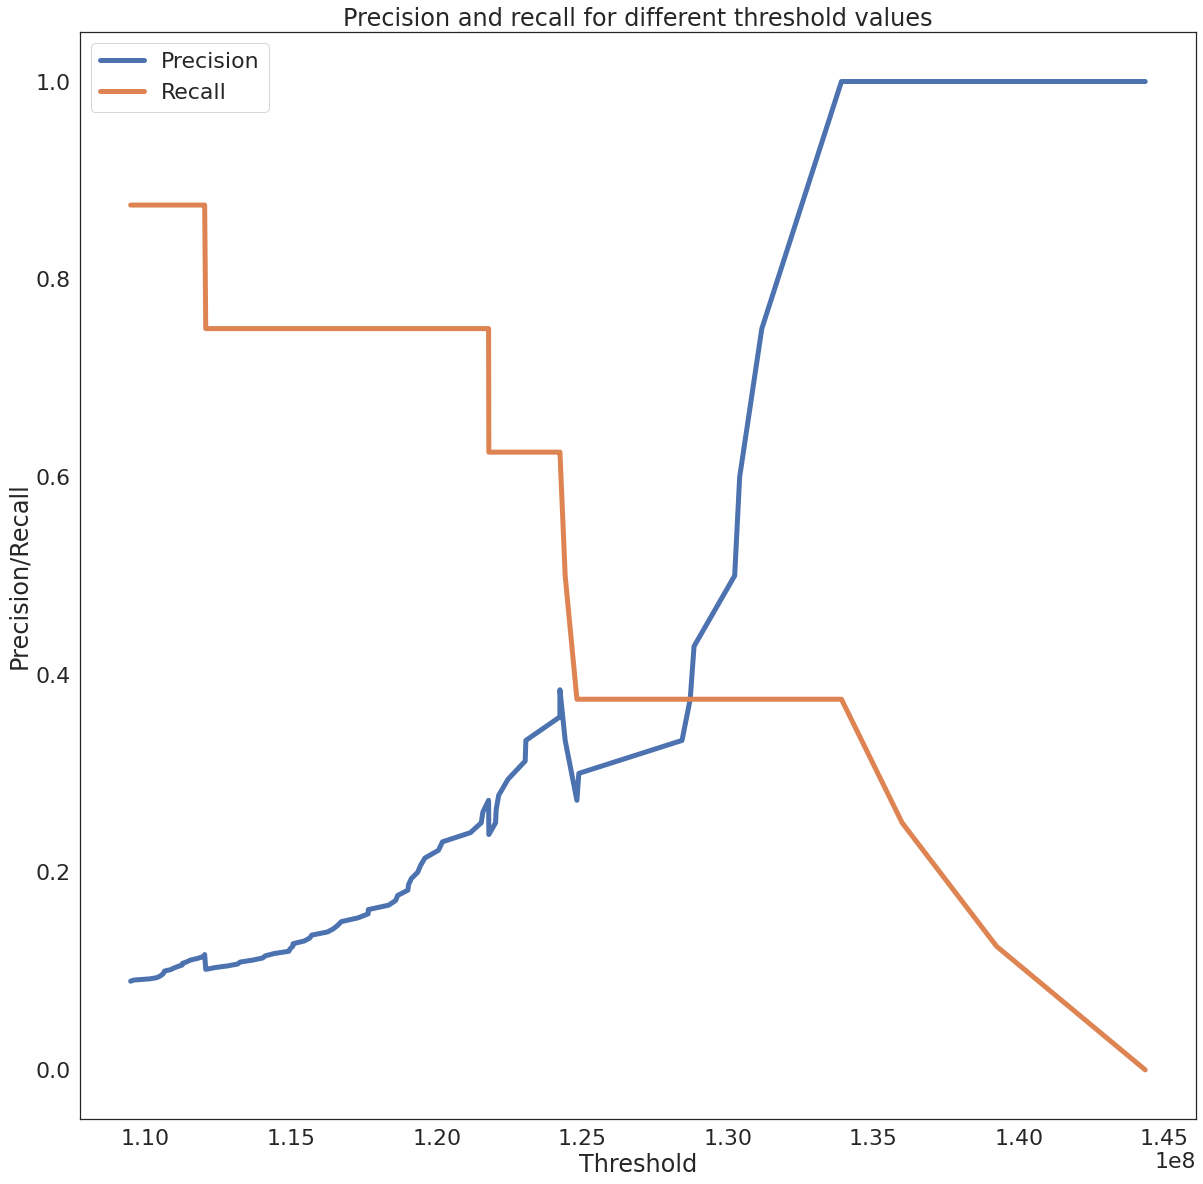

In [6]:
collect_metrics('dhcp_vae_model_full_16x16comp', train ,test)

### dhcp_standardized_model_full

Train MSE: 0.00079563865
Test MSE: 0.00091508264
Train - Positive Changes:  0.026662838984366867 Negative Changes:  -0.00564207063869317
Test - Positive Changes:  0.031223844530455225 Negative Changes:  -0.004766090981066851
Train - Avg Size:  3.4528087855475893 Avg Clust:  9.629213483146067
Test - Avg Size:  2.796401515151515 Avg Clust:  7.375


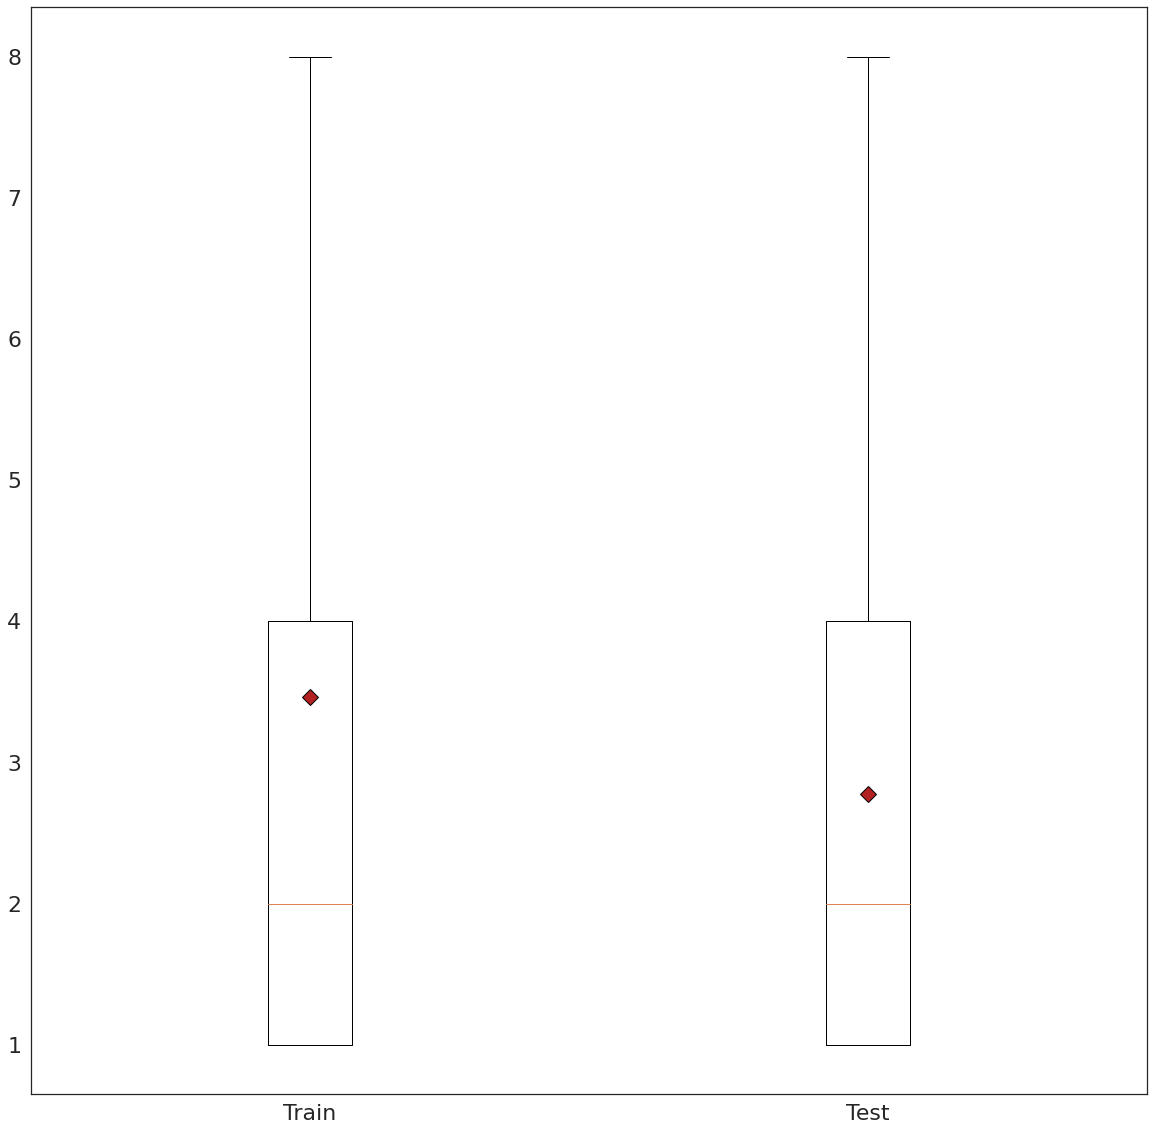

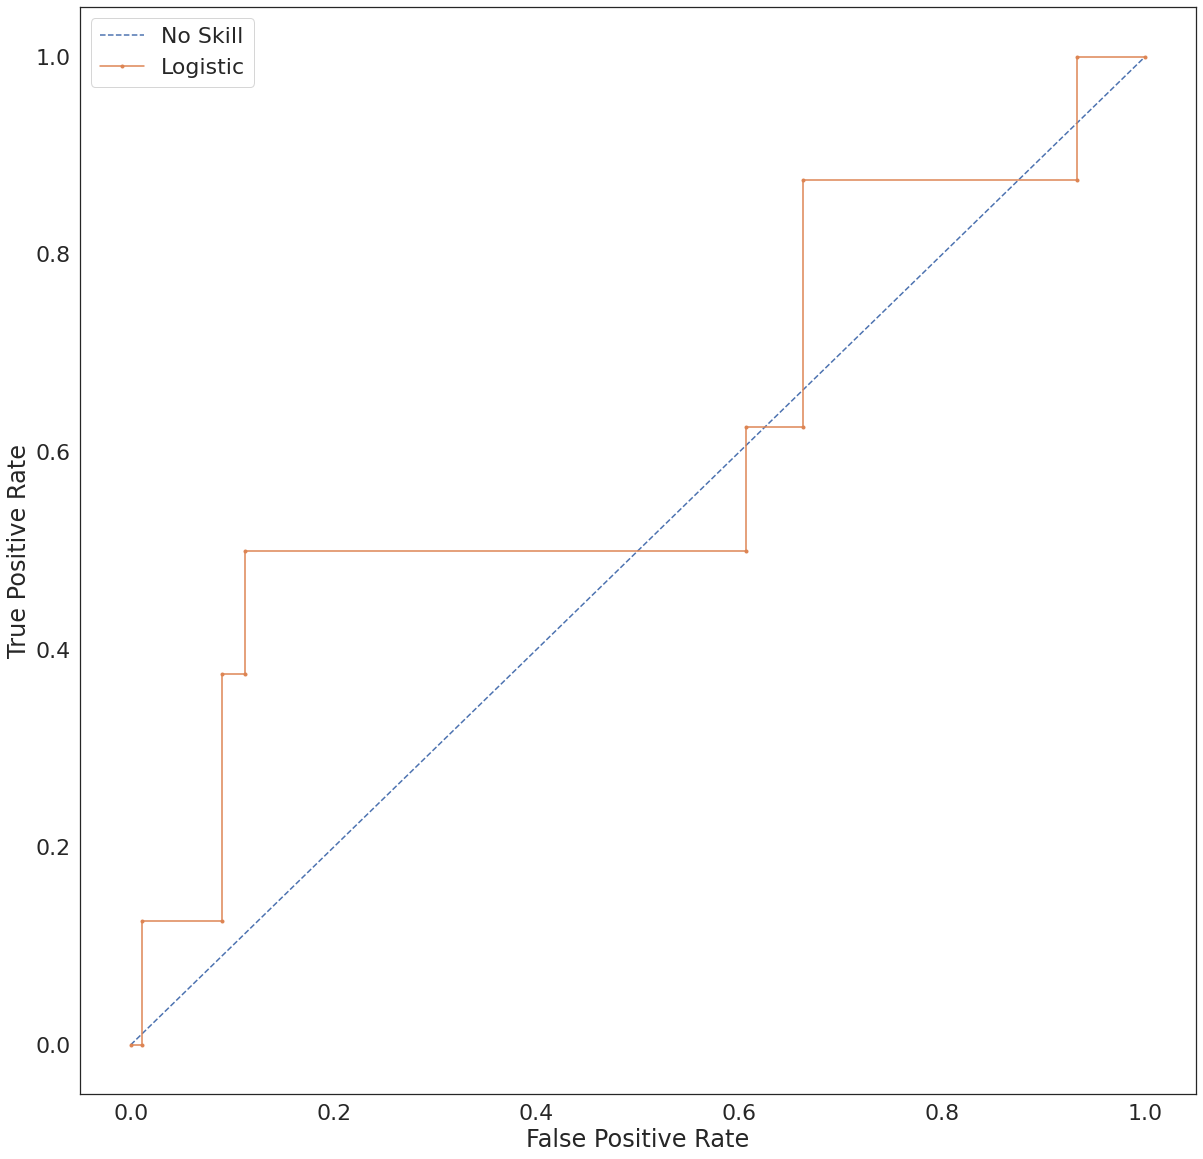

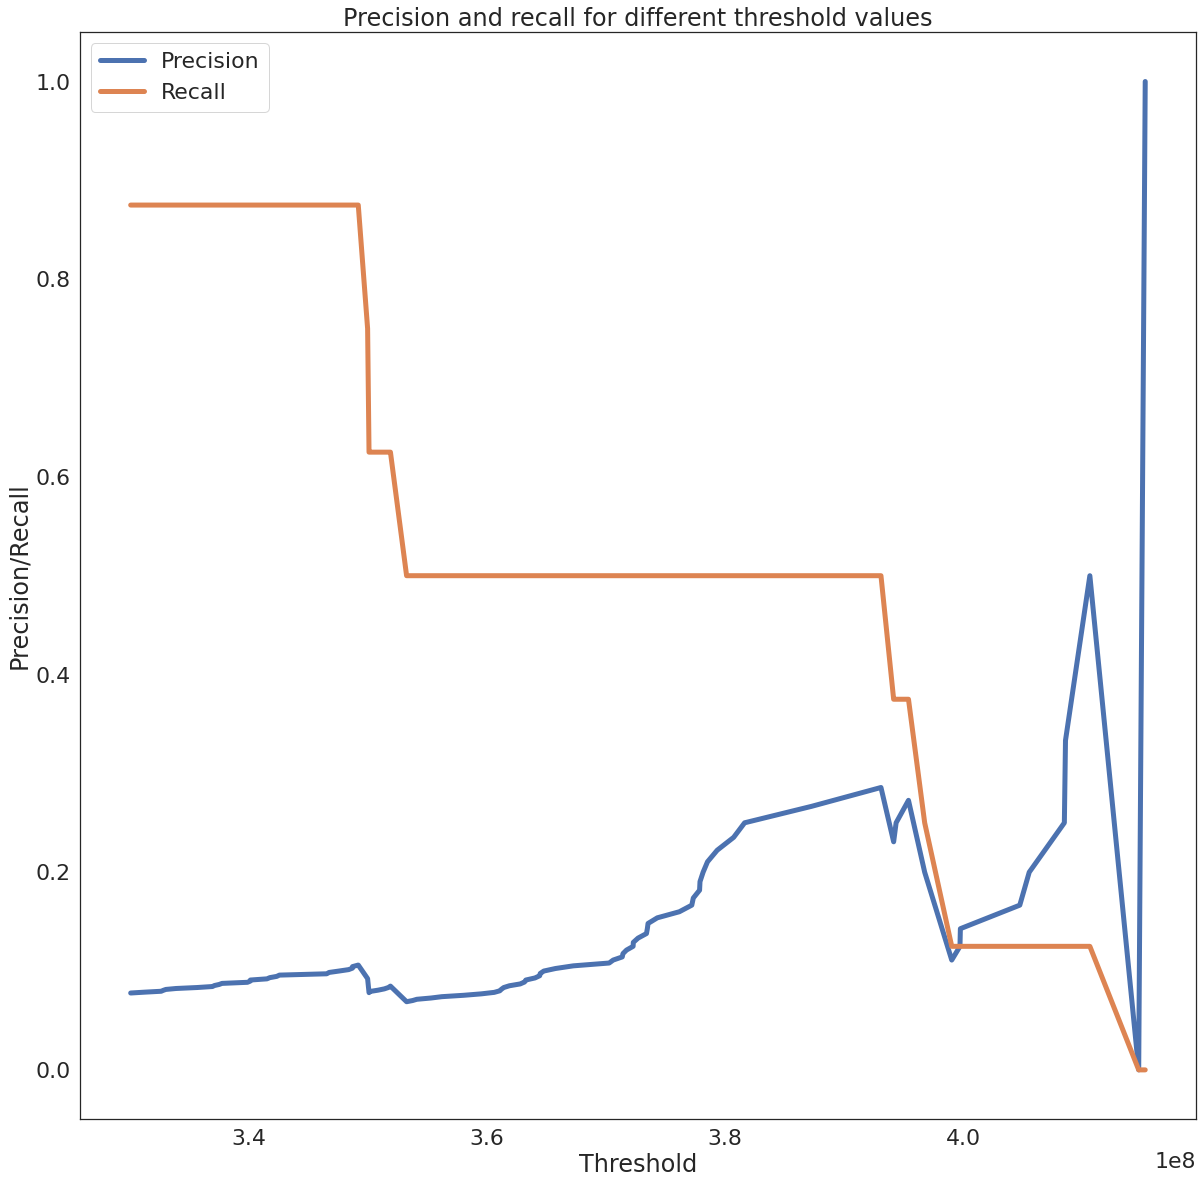

In [6]:
collect_metrics('dhcp_standardized_model_full', train ,test)

### dhcp_standardized_model_full_8x8comp

Train MSE: 0.0013898872
Test MSE: 0.0017680648
Train - Positive Changes:  0.027987705718965965 Negative Changes:  -0.009270596183634431
Test - Positive Changes:  0.03442447342445481 Negative Changes:  -0.009804208083604809
Train - Avg Size:  4.383416292040473 Avg Clust:  13.179775280898877
Test - Avg Size:  4.07062014782603 Avg Clust:  13.875


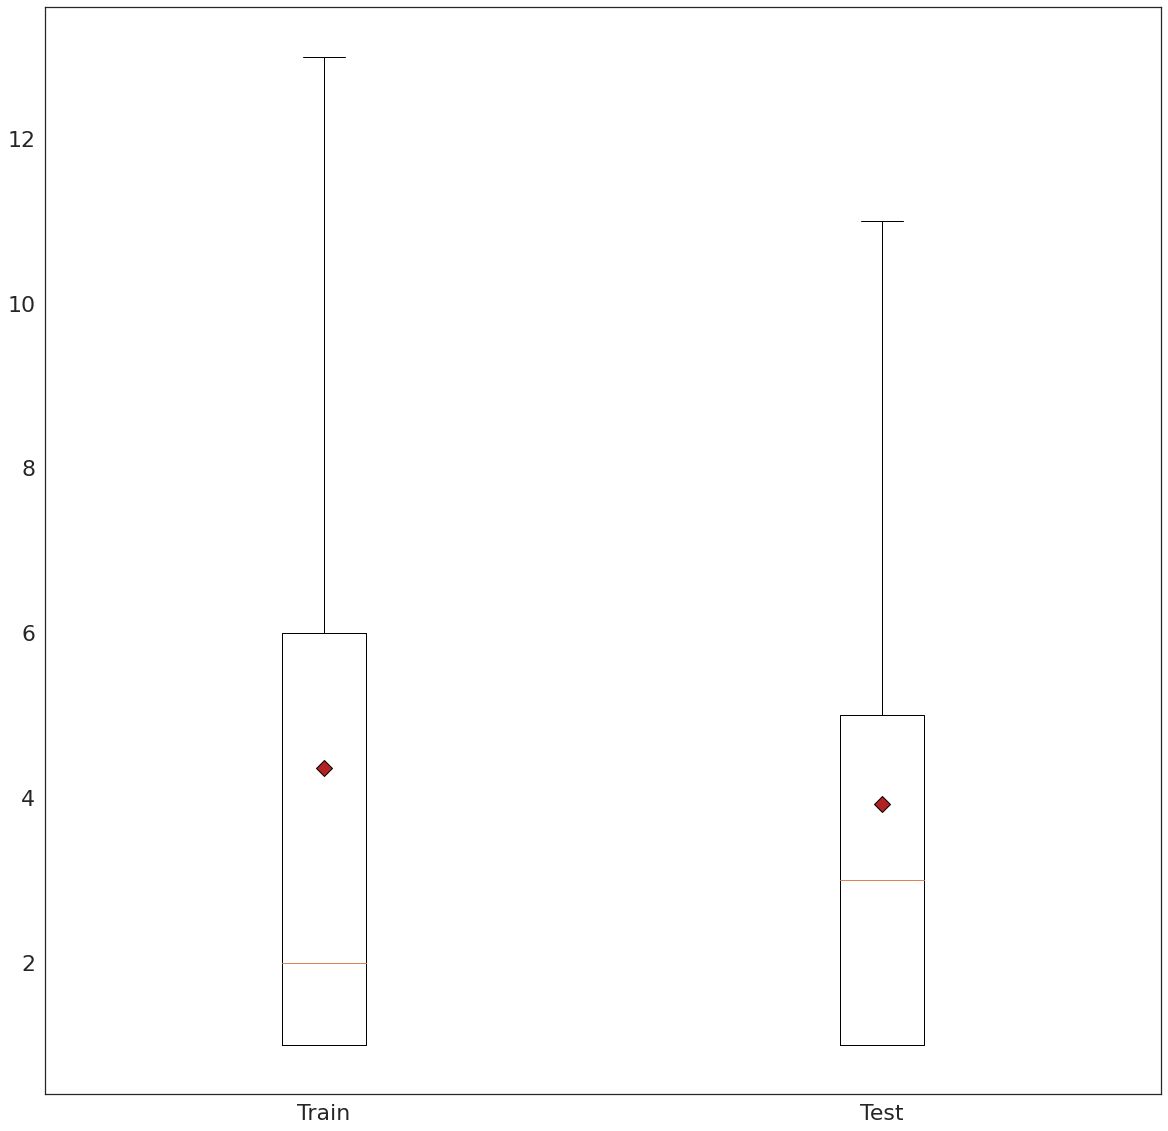

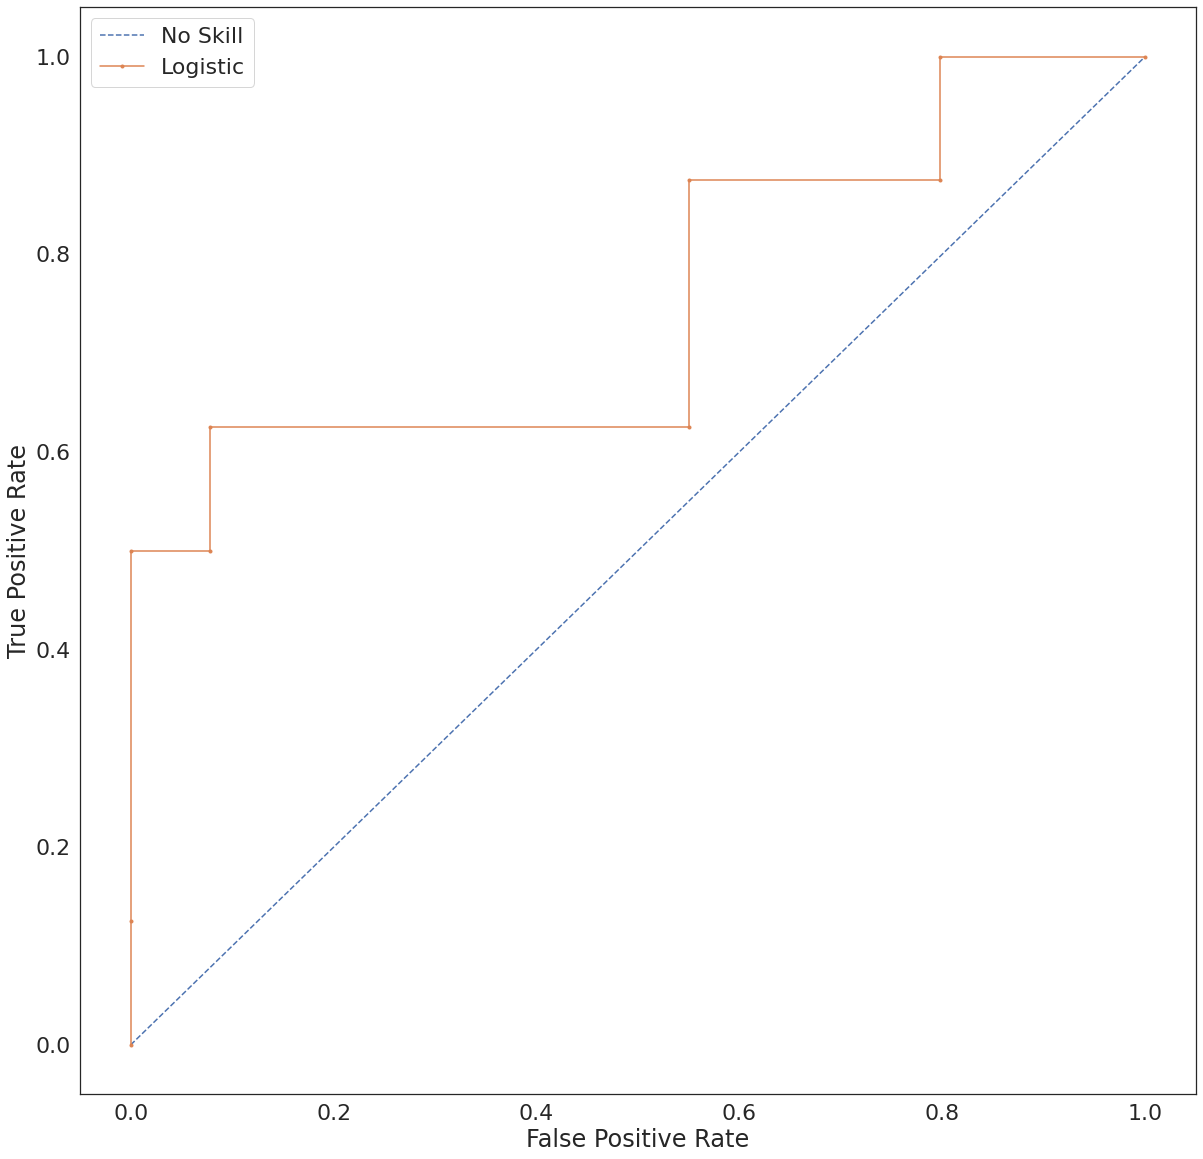

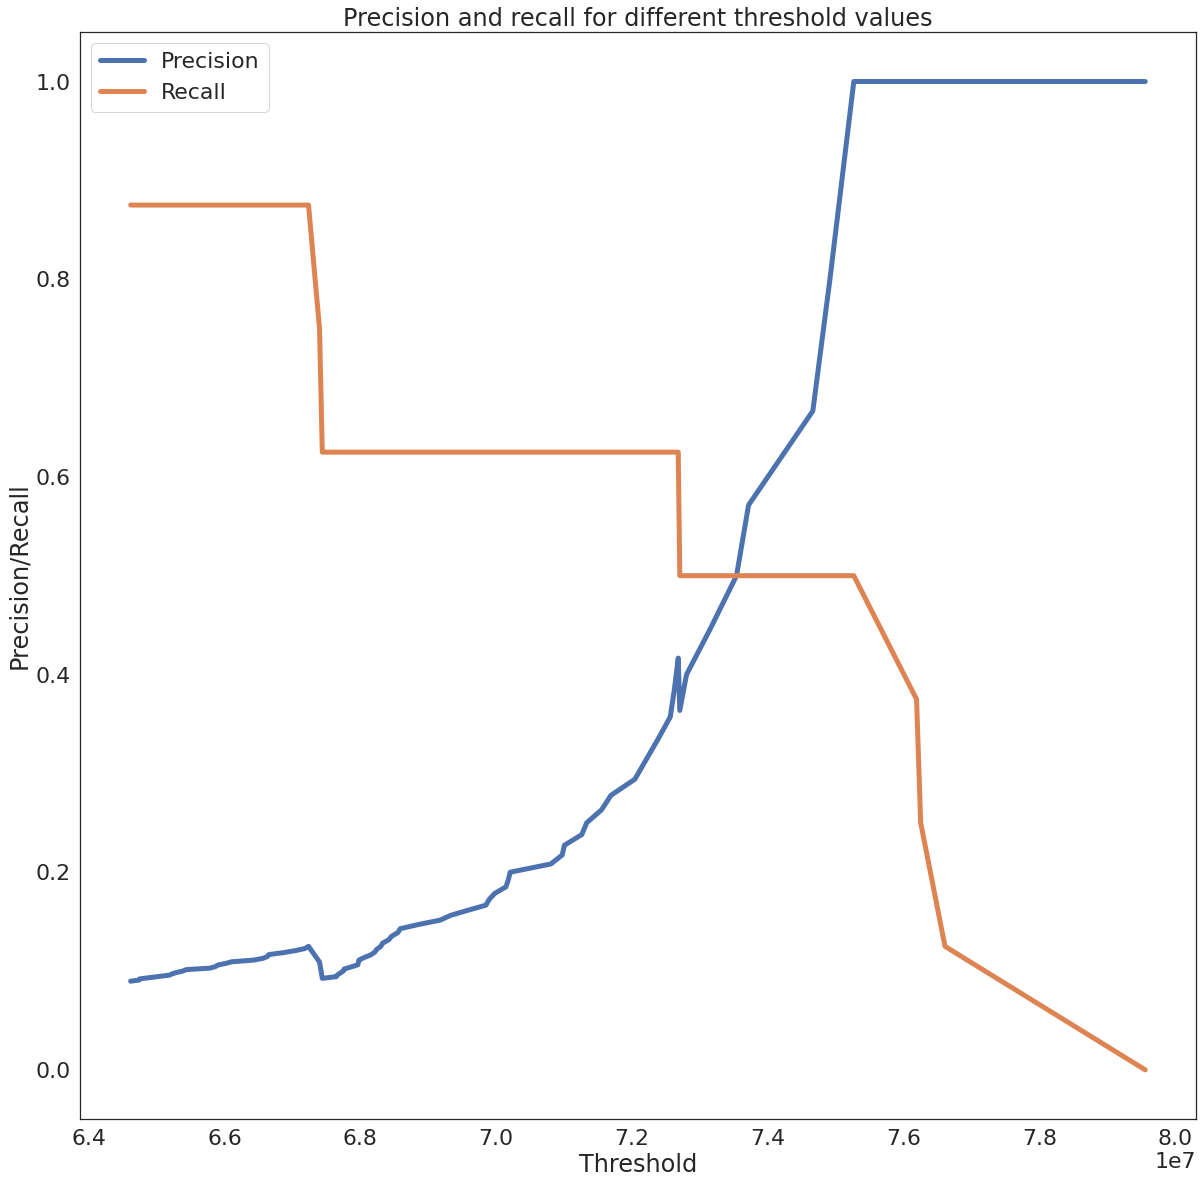

In [6]:
collect_metrics('dhcp_standardized_model_full_8x8comp', train ,test)